# Motivation
There are experiments in which more than one type of cels are in probe. In big experiments, when scientist needs to proceed hundreds of stacks manual spliting segmentaion results on subsets will consume to long time. Also some markers can be outside nucleus territory. 
So this need to be done on stack. 

## Content

In thsi notebbok we will show how bioinformatics can use PartSeg components to conduct segmentation and add his own code for classify neurons type. Finally different types of neurons will be saved in separate directories.



This steps are need, because partseg in this moment is not avaliable as package.

In [1]:
import sys 
import os
notebook_path = !pwd 
sys.path.append(os.path.join(os.path.dirname(notebook_path[0]), "src"))

## Base imports 

In [2]:
import json
import numpy as np 
from collections import defaultdict
from tiff_image.image_reader import ImageReader
import segmentation_mask.stack_gui_main
from segmentation_mask.stack_settings import StackSettings
from partseg_utils.segmentation.segmentation_algorithm import ThresholdAlgorithm
from partseg_utils.image_operations import dilate
from segmentation_mask.io_functions import load_stack_segmentation, save_components

In [3]:
data_path = "/home/czaki/Obrazy/PartSeg/typy_neuronow/"

## Prepare data
In this part there is shown how to read data and create or load segmentation

### Parameters of segmentaion 

Parameters  of segmentation can be read from file  

In [5]:
with open(os.path.join(data_path, "segment_data.json"), 'r') as ff:
    parameters = json.load(ff, object_hook=StackSettings.decode_hook)

or setted manually

In [6]:
from partseg_utils.segmentation.noise_filtering import GaussType
parameters = {'channel': 3,
 'threshold': {'name': 'Manual', 'values': {'threshold': 19000}},
 'minimum_size': 8000,
 'close_holes': True,
 'close_holes_size': 200,
 'smooth_border': True,
 'smooth_border_radius': 0,
 'noise_removal': {'name': 'Gauss',
  'values': {'gauss_type': GaussType.Layer, 'radius': 1.0}},
 'side_connection': False,
 'use_convex': True}

### Read data

In [7]:
image = ImageReader.read_image(os.path.join(data_path, "DMSO_120min_2_1.lsm"))

### Calculate Segentation 

In [8]:
segment = ThresholdAlgorithm()
segment.set_image(image)
segment.set_parameters(**parameters)

In [9]:
result = segment.calculation_run(print)
segmentation = result.segmentation

Gauss 0
Threshold calculation 1
Threshold calculated 2
Filing holes 3
Components calculating 4
Smoothing borders 5


## Load segmentaion

In [10]:
segmentation, metadata = load_stack_segmentation(os.path.join(data_path, "DMSO_120min_2_1.seg"))

# Classify neurons

There are three types of neurons:
1. With red markers insideand green marker near surface
2. With green marker near surface, but without red marker
3. Without both markers

**In code channels are numbered from 0**

In [11]:
neuron_type_dict = defaultdict(list)
for component_number in range(1, segmentation.max() + 1):
    current_component_area = segmentation == component_number
    value_red = np.quantile(image.get_channel(0)[current_component_area], 0.75)
    # radius is 3, 9, 9 because voxel size is 210x70x70nm and voxel size is in pixels, not physicla units
    dilate_mask = dilate(current_component_area, (3, 9 ,9), False) 
    dilate_mask[current_component_area] = 0
    value_green = np.quantile(image.get_channel(1)[current_component_area], 0.75)
    if value_red > 10000:
        if value_green > 10000:
            neuron_type_dict["red"].append(component_number)
            continue
        else:
            neuron_type_dict["unexpected"].append(component_number)
            continue
    elif value_green > 10000:
        neuron_type_dict["green"].append(component_number)
        continue
    neuron_type_dict["none"].append(component_number)
print(neuron_type_dict)
    
    

defaultdict(<class 'list'>, {'none': [1, 7], 'green': [2, 3], 'red': [4, 5, 6]})


In [9]:
save_path = os.path.join(data_path, "DMSO_120min_2_1")
for key, value in neuron_type_dict.items():
    dir_path = os.path.join(save_path, key)
    os.makedirs(dir_path, exist_ok=True)
    save_components(image, value, segmentation, dir_path)

# Appendix

## How preview result in notebook

In this part I show show preview result of segmentation in notebook using matplotlib. It can be also done with k3d.

In [13]:
from matplotlib import pyplot as plt 
%matplotlib notebook 

In [14]:
from partseg_utils.color_image.color_image_base import color_image 
from partseg_utils.color_image.color_image import add_labels

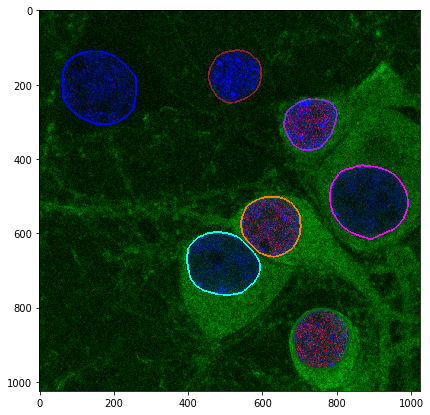

In [15]:
layer_num = 28
layer = image.get_layer(0, layer_num)
components_to_show = np.ones(result.segmentation.max()+1, dtype=np.uint8)
colored_image = color_image(layer, colors=["BlackRed", "BlackGreen", "BlackBlue", None], min_max=image.get_ranges())
add_labels(colored_image, result.segmentation[layer_num], 1, True, 2, components_to_show)
plt.figure(figsize=(7, 7))
plt.imshow(colored_image)
plt.show()
# plt.imshow(result.segmentation[layer_num])

## Veriffy segmentaion 
In example stack DMSO_120min_2_4.lsm on standard parameters, there are two cases that should be filtered. 
1. Three nucleus that are too cloase and are segmentaed as one component (number 1)
2. Nucles that touch border of image (numbers 10, 11, 12)

When calculating sphericity (proportion beetwen volume and volume of sphere with same diameter like component.
Threshold used in this step shoud depend on data. There are cell types with realy irregular shapes 


In [17]:
from segmentation_analysis.statistics_calculation import Diameter, Volume
from math import pi
from copy import deepcopy

In [18]:
parameters_app1 = deepcopy(parameters)
parameters_app1['use_convex'] = False

In [19]:
image_app1 = ImageReader.read_image(os.path.join(data_path, "DMSO_120min_2_4.lsm"))
segment = ThresholdAlgorithm()
segment.set_image(image_app1)
segment.set_parameters(**parameters_app1)
result_app1= segment.calculation_run(print)
segmentation_app1 = result_app1.segmentation

Gauss 0
Threshold calculation 1
Threshold calculated 2
Filing holes 3
Components calculating 4
Smoothing borders 5


In [20]:
good_neurons = []
for component_number in range(1, segmentation_app1.max() + 1):
    current_component_area = segmentation_app1 == component_number
    # checking if touch borders 
    coords = np.nonzero(current_component_area)
    if 0 == np.min(coords):
        continue
    touch = False
    for axis_cords, max_size in zip(coords, current_component_area.shape):
        if np.max(axis_cords) == max_size - 1:
            touch = True
            break
    if touch:
        continue
    diameter = Diameter.calculate_property(current_component_area, voxel_size=image_app1.spacing, result_scalar=1)
    volume = Volume.calculate_property(current_component_area, voxel_size=image_app1.spacing, result_scalar=1)
    # calculate 
    if (4/3 * pi * (diameter/2)**3)/volume > 2.5:
        continue 
    good_neurons.append(component_number)
print(good_neurons)

[2, 3, 4, 5, 6, 7, 8, 9]


#### All components

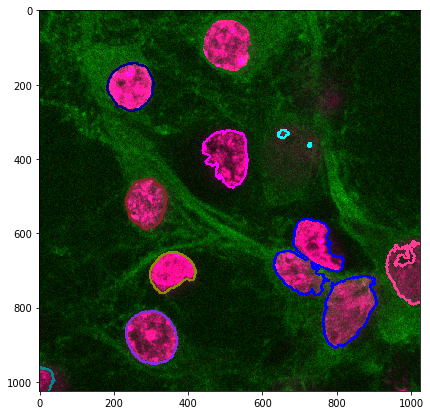

In [21]:
layer_num = 30
layer = image_app1.get_layer(0, layer_num)
components_to_show = np.ones(result_app1.segmentation.max()+1, dtype=np.uint8)
colored_image = color_image(layer, colors=["BlackRed", "BlackGreen", "BlackBlue", "BlackMagenta"], min_max=image.get_ranges())
add_labels(colored_image, result_app1.segmentation[layer_num], 1, True, 3, components_to_show)
plt.figure(figsize=(7, 7))
plt.imshow(colored_image)
plt.show()

#### Filtered components

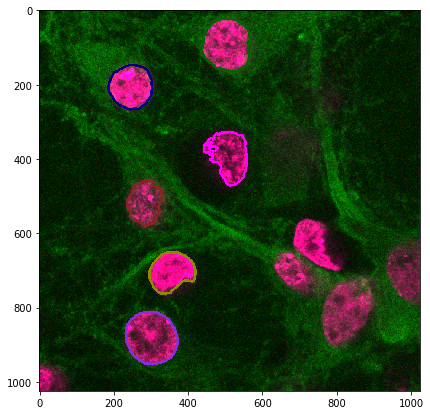

In [22]:
layer_num = 28
layer = image_app1.get_layer(0, layer_num)
components_to_show = np.zeros(result_app1.segmentation.max()+1, dtype=np.uint8)
components_to_show[good_neurons] = 1
colored_image = color_image(layer, colors=["BlackRed", "BlackGreen", "BlackBlue", "BlackMagenta"], min_max=image.get_ranges())
add_labels(colored_image, result_app1.segmentation[layer_num], 1, True, 3, components_to_show)
plt.figure(figsize=(7, 7))
plt.imshow(colored_image)
plt.show()